In [1]:
import h5py
import numpy as np
from scipy.optimize import curve_fit
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import os
import re

def fit_ImSigma_4(iw, gamma, alpha, beta, delta, delta2):
    ImSigma = -gamma - alpha * iw - beta * iw**2 - delta * iw**3 - delta2 * iw**4
    return ImSigma

def fit_ImSigma_3(iw, gamma, alpha, beta, delta):
    ImSigma = -gamma - alpha * iw - beta * iw**2 - delta * iw**3
    return ImSigma

def fit_ImSigma_2(iw, gamma, alpha, beta):
    ImSigma = -gamma - alpha * iw - beta * iw**2
    return ImSigma

def fit_ImSigma_1(iw, gamma, alpha):
    ImSigma = gamma - alpha * iw
    return ImSigma



In [6]:
PATH = "/gpfs/data/fs72150/springerd/Projects/DynamicalU/PhaseSpace/Ust_vs_Usc/beta20/w0_4"
U_st = []
U_sc = []
data = {}
ivmaxs = []
iv0s = []
popt2s = []
fitpoints = 10

for subdir, dirs, files in os.walk(PATH):
    for file in files:
        if "oo_2" in file:
            U1 = re.findall(r'\d+', subdir)[4]
            U2 = re.findall(r'\d+', subdir)[5]

            if int(U1) not in U_st:
                U_st.append(int(U1))
            if int(U2) not in U_sc:
                U_sc.append(int(U2))
            
            if str(U1) not in data.keys():
                data[str(U1)] = {}
            if str(U2) not in data[str(U1)].keys():
                data[str(U1)][str(U2)] = {}
            
            filename = subdir+'/'+file
#             print(filename)
            with h5py.File(filename, "r") as f:
                iv = np.array(f['.axes']['iw'][:])
                tau = np.array(f['.axes']['tau'][:])
                siv = np.array(f['dmft-last']['ineq-001']['siw']['value'])
                gtau = np.array(f['dmft-last']['ineq-001']['gtau']['value'])
            iv0 = int(iv.shape[0]/2)
            nn = iv0 + fitpoints
            ivmax = iv0 + 50
            iv_limit = iv[iv0:nn].real
            siv_limit = (siv[0,0,iv0:nn]).imag

#             popt2, pcov2 = curve_fit(fit_ImSigma_1, iv_limit, siv_limit)
#             popt2, pcov2 = curve_fit(fit_ImSigma_2, iv_limit, siv_limit)
            popt2, pcov2 = curve_fit(fit_ImSigma_4, iv_limit, siv_limit)
            popt2s.append(popt2)

#             fit_sigma_2 = fit_ImSigma_1(iv_limit, popt2[0], popt2[1])
#             fit_sigma_2 = fit_ImSigma_2(iv_limit, popt2[0], popt2[1], popt2[2])
            fit_sigma_2 = fit_ImSigma_4(iv_limit, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4])

            data[str(U1)][str(U2)]["iv"] = iv
            data[str(U1)][str(U2)]["siv"] = siv
            data[str(U1)][str(U2)]["gtau"] = gtau
            data[str(U1)][str(U2)]["fit_siv"] = fit_sigma_2
            data[str(U1)][str(U2)]["Z"] = round(1/(1+popt2[1]), 2)
            data[str(U1)][str(U2)]["alpha"] = popt2[1]

U_sc.sort()
U_st.sort()


In [7]:
data_np = {}
data_np["Z"] = np.zeros((len(U_st), len(U_sc),3))
data_np["alpha"] = np.zeros((len(U_st), len(U_sc),3))
data_np["siv0"] = np.zeros((len(U_st), len(U_sc),3), dtype=complex)
data_np["siv_diff"] = np.zeros((len(U_st), len(U_sc),3), dtype=complex)
data_np["gtaubetahalf"] = np.zeros((len(U_st), len(U_sc),3))

k = 0
for u in U_st:
    l = 0
    for v in U_sc:
        data_np["Z"][k,l,0] = u
        data_np["Z"][k,l,1] = v
        data_np["Z"][k,l,2] = data[str(u)][str(v)]["Z"]

        data_np["alpha"][k,l,0] = u
        data_np["alpha"][k,l,1] = v
        data_np["alpha"][k,l,2] = data[str(u)][str(v)]["alpha"]

        data_np["siv0"][k,l,0] = u
        data_np["siv0"][k,l,1] = v
        data_np["siv0"][k,l,2] = data[str(u)][str(v)]["siv"][0,0,1000]

        data_np["siv_diff"][k,l,0] = u
        data_np["siv_diff"][k,l,1] = v
        data_np["siv_diff"][k,l,2] = data[str(u)][str(v)]["siv"][0,0,1001] - data[str(u)][str(v)]["siv"][0,0,1000]

        data_np["gtaubetahalf"][k,l,0] = u
        data_np["gtaubetahalf"][k,l,1] = v
        data_np["gtaubetahalf"][k,l,2] = data[str(u)][str(v)]["gtau"][0,0,500]

        l+=1
    k+=1
data_np["Z"][:,:,2][data_np["Z"][:,:,2]<0] = 0.0
data_np["Z"][:,:,2][data_np["Z"][:,:,2]>1] = 0.0


In [10]:
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'surface'},{'type': 'surface'},{'type': 'surface'}]],
#     specs=[[{'type': 'surface'},{'type': 'surface'},{'type': 'surface'}],[{'type': 'surface'},{'type': 'surface'},{'type': 'surface'}]],
    subplot_titles=[])# , subplot_titles=(titles))

fig.add_trace(
go.Surface(x=U_st, y=U_sc, z=data_np["Z"][:,:,2], colorscale='viridis', showscale=False),
row=1, col=1)

fig.add_trace(
go.Surface(x=U_st, y=U_sc, z=data_np["siv_diff"][:,:,2].imag, colorscale='viridis', showscale=False),
# go.Surface(x=U_st, y=U_sc, z=data_np["alpha"][:,:,2], colorscale='viridis', showscale=False),
row=1, col=2)

fig.add_trace(
go.Surface(x=U_st, y=U_sc, z=data_np["gtaubetahalf"][:,:,2], colorscale='viridis', showscale=False),
row=1, col=3)


fig.update_scenes(xaxis_title_text='U_static',  
                  yaxis_title_text='U_screen')

fig.update_yaxes(title_text="Date", row = 1, col = 1)

camera = dict(
    eye=dict(x=-0.5, y=-2.5, z=1.)
)
aspectratio = dict(x=1, y=1, z=1.5)
# camera_position()


fig.update_layout(
    title=r'$\beta=20, \omega_0=4.0$',
    autosize=True,
    width=1900, height=800,
    margin=dict(l=10, r=5, b=0, t=35),
    scene1 = dict(
        zaxis_title_text ="Z",
    ),
    scene2 = dict(
        zaxis_title_text="siv(1)-siv(0)",
    ),
    scene3 = dict(
        zaxis_title_text ="gtau(beta/2)",
    ),
#     scene = dict(zaxis = dict(range=[-1,1],),),
)

fig.write_html("/home/fs72150/springerd/Projects/DynamicalU/w4c0_beta20.html")


In [15]:
u = 200
v = 80
print(data[str(u)][str(v)]["Z"])



0.68


[200, 229, 260, 290, 320, 350, 380, 409, 440, 469, 500]
[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
[-0.25364876 -0.72616673 -1.06073925 -1.28484125 -1.42305731 -1.49708169
 -1.52571833 -1.52488082 -1.50759245 -1.48398616]
0.33


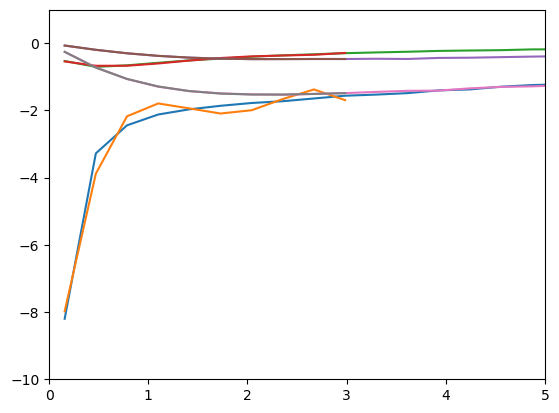

In [5]:
print(U_st)
print(U_sc)
u = 500
v = 200
plt.figure(1)
plt.plot(iv[1000:1050], data[str(u)][str(v)]["siv"][0,0,1000:1050].imag)
plt.plot(iv[1000:1000+fitpoints], data[str(u)][str(v)]["fit_siv"][:])

u = 200
v = 200
plt.plot(iv[1000:1050], data[str(u)][str(v)]["siv"][0,0,1000:1050].imag)
plt.plot(iv[1000:1000+fitpoints], data[str(u)][str(v)]["fit_siv"][:])

u = 200
v = 0
plt.plot(iv[1000:1050], data[str(u)][str(v)]["siv"][0,0,1000:1050].imag)
plt.plot(iv[1000:1000+fitpoints], data[str(u)][str(v)]["fit_siv"][:])

u = 500
v = 0
plt.plot(iv[1000:1050], data[str(u)][str(v)]["siv"][0,0,1000:1050].imag)
plt.plot(iv[1000:1000+fitpoints], data[str(u)][str(v)]["fit_siv"][:])

plt.ylim([-10,1])
plt.xlim([0,5])

print(data[str(u)][str(v)]["fit_siv"])
print(data[str(u)][str(v)]["Z"])

In [62]:
data_np["Z"]

array([[[ 2.00e+02,  0.00e+00,  9.10e-01],
        [ 2.00e+02,  2.00e+01,  9.20e-01],
        [ 2.00e+02,  4.00e+01,  9.20e-01],
        [ 2.00e+02,  6.00e+01,  9.10e-01],
        [ 2.00e+02,  8.00e+01,  9.00e-01],
        [ 2.00e+02,  1.00e+02,  8.80e-01],
        [ 2.00e+02,  1.20e+02,  8.50e-01],
        [ 2.00e+02,  1.40e+02,  8.30e-01],
        [ 2.00e+02,  1.60e+02,  8.10e-01],
        [ 2.00e+02,  1.80e+02,  8.00e-01],
        [ 2.00e+02,  2.00e+02,  8.30e-01]],

       [[ 2.80e+02,  0.00e+00,  8.80e-01],
        [ 2.80e+02,  2.00e+01,  8.90e-01],
        [ 2.80e+02,  4.00e+01,  8.90e-01],
        [ 2.80e+02,  6.00e+01,  8.80e-01],
        [ 2.80e+02,  8.00e+01,  8.60e-01],
        [ 2.80e+02,  1.00e+02,  8.50e-01],
        [ 2.80e+02,  1.20e+02,  8.20e-01],
        [ 2.80e+02,  1.40e+02,  8.10e-01],
        [ 2.80e+02,  1.60e+02,  7.80e-01],
        [ 2.80e+02,  1.80e+02,  7.90e-01],
        [ 2.80e+02,  2.00e+02,  9.10e-01]],

       [[ 3.60e+02,  0.00e+00,  8.50e-01],
       